In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from utils.testcase_creator import *
from optimization.sa.task_graph import PrecedenceGraph
import networkx as nx
import main
from pathlib import Path
from input.input_parameters import InputParameters, EMode, Timeouts

In [2]:
def _repr_html_monkeypatches(dot):
    """
    Monkey-patching for ``pydot.Dot._repr_html_()` for rendering in jupyter cells.

    :param dot:
        a `pydot.Dot()` instance

    .. Note::
        Had to use ``_repr_html_()`` and not simply ``_repr_svg_()`` because
        (due to https://github.com/jupyterlab/jupyterlab/issues/7497)

    """
    pan_zoom_json = "{controlIconsEnabled: true, zoomScaleSensitivity: 0.4, fit: true}",
    element_styles = "width: 100%; height: 300px;",
    container_styles = ""
    svg_txt = dot._repr_svg_()
    html = f"""
        <div class="svg_container">
            <style>
                .svg_container {{
                    {container_styles}
                }}
                .svg_container SVG {{
                    {element_styles}
                }}
            </style>
            <script src="http://ariutta.github.io/svg-pan-zoom/dist/svg-pan-zoom.min.js"></script>
            <script type="text/javascript">
                var scriptTag = document.scripts[document.scripts.length - 1];
                var parentTag = scriptTag.parentNode;
                svg_el = parentTag.querySelector(".svg_container svg");
                svgPanZoom(svg_el, {pan_zoom_json});
            </script>
            {svg_txt}
        </</>
    """
    return html

In [3]:
from graphviz import Digraph
from input.model.nodes import switch
from input.model.task import ETaskType
from IPython.display import HTML

def visualize_topo(solution):
    testcase = solution.tc
    dot = Digraph(comment="base_topology", node_attr={"shape": "record"})
    for node in testcase.N.values():
        if isinstance(node, switch):
            dot.node(node.id, label=node.id + " (SW)", shape="circle")
        else:
            task_list = testcase.T_g[node.id]
            task_list = [task for task in task_list if task.type == ETaskType.NORMAL]
            # Create task rows
            task_rows = []

            for i in range(0, len(task_list), 3):
                task_row = "{"
                task_row += task_list[i].id if i < len(task_list) else ""
                task_row += "|" + task_list[i + 1].id if i + 1 < len(task_list) else ""
                task_row += "|" + task_list[i + 2].id if i + 2 < len(task_list) else ""
                task_row += "}"
                task_rows.append(task_row)

            # Assemble label
            layout_label = "{"
            layout_label += node.id + " (ES)"
            for task_row in task_rows:
                layout_label += "|" + task_row
            layout_label += "}"

            dot.node(node.id, label=layout_label)

    for link in testcase.L.values():
        dot.edge(link.src.id, link.dest.id)
        
    return HTML(_repr_html_monkeypatches(dot))

In [4]:
from IPython.display import Image, display

def visualize_DAGs(solution):
    testcase = solution.tc
    tg = PrecedenceGraph.from_applications(testcase)
    pdot = nx.drawing.nx_pydot.to_pydot(tg.DAG)
    return Image(pdot.create_png())

Found possible graph. Is connected: True


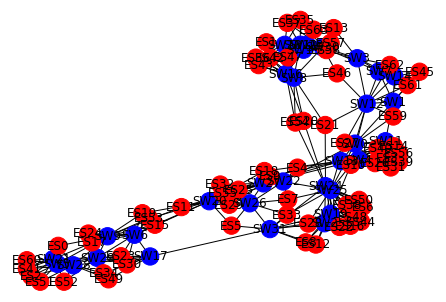

Creating apps with 7 tasks


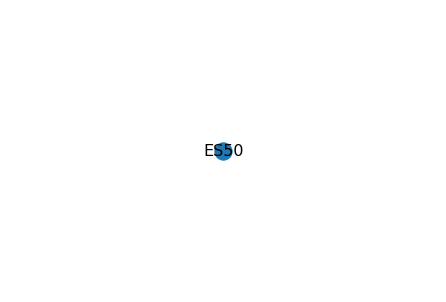

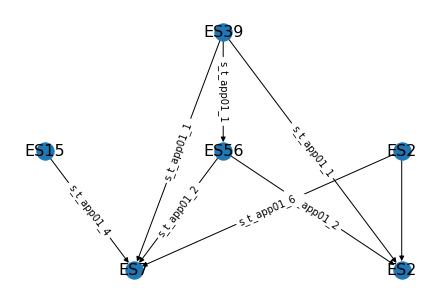

Creating apps with 7 tasks


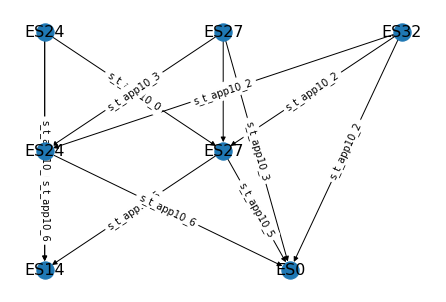

Creating apps with 7 tasks


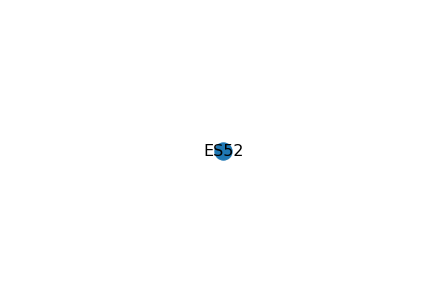

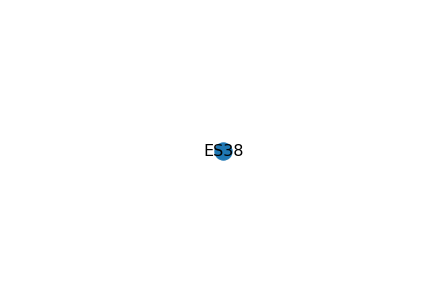

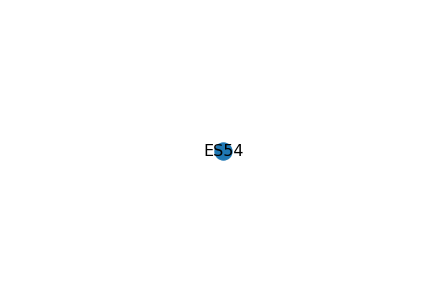

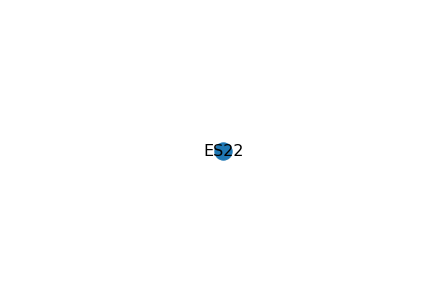

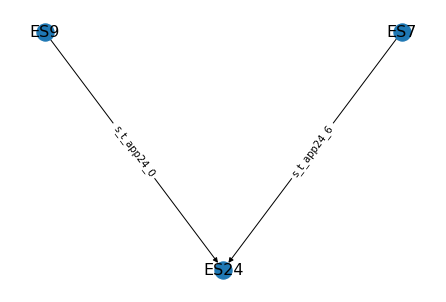

Creating apps with 7 tasks


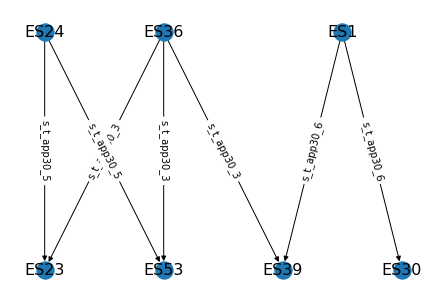

Creating apps with 7 tasks


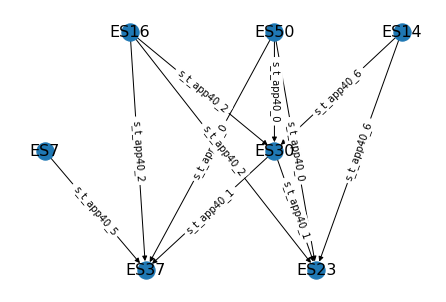

Creating apps with 7 tasks


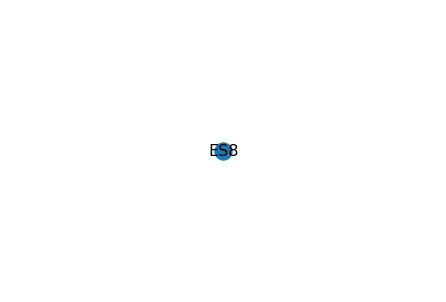

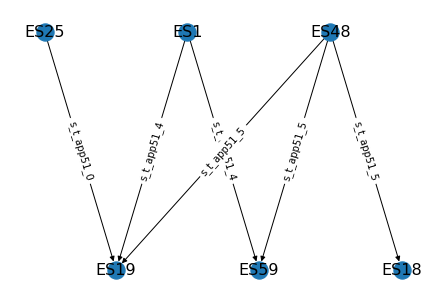

Creating apps with 7 tasks


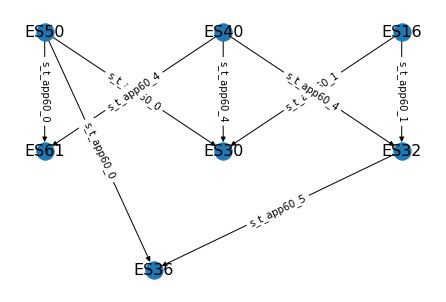

Creating apps with 7 tasks


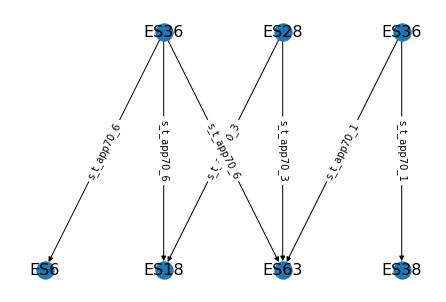

Creating apps with 7 tasks


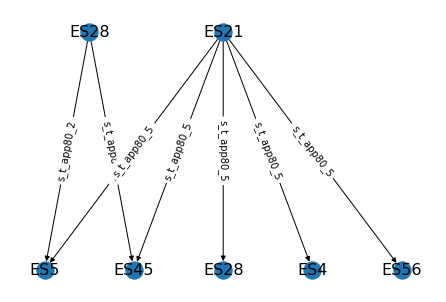

Creating apps with 7 tasks


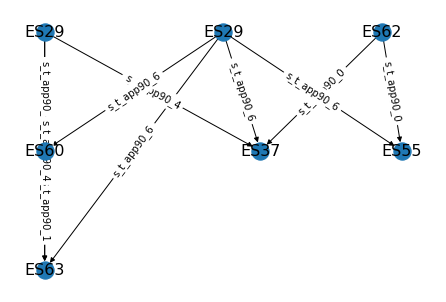

Creating apps with 7 tasks


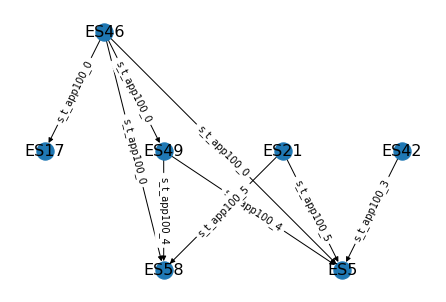

Creating apps with 7 tasks


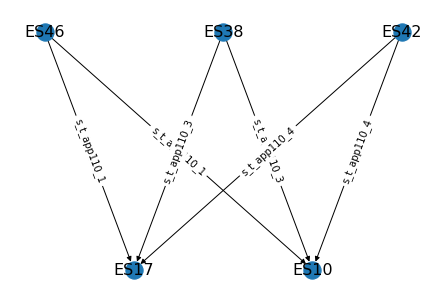

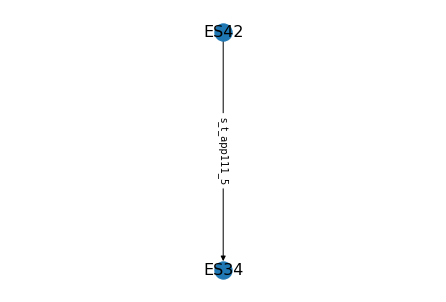

Creating apps with 7 tasks


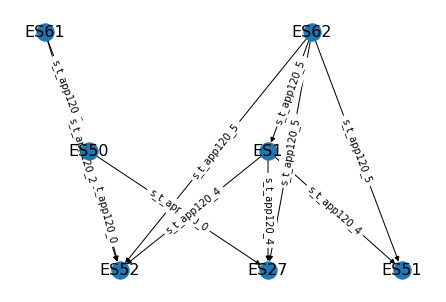

Creating apps with 7 tasks


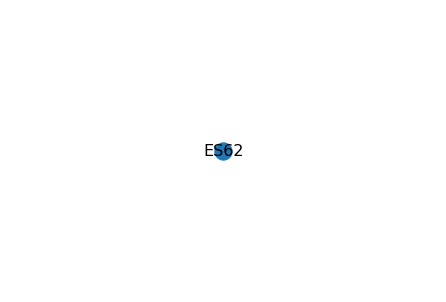

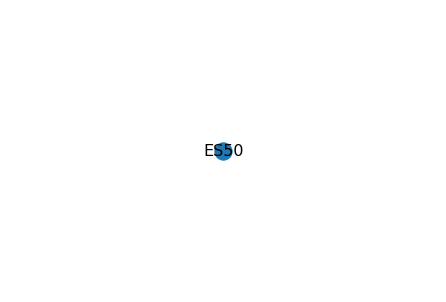

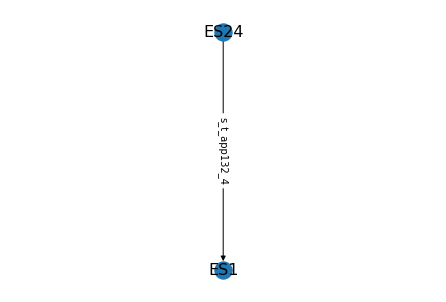

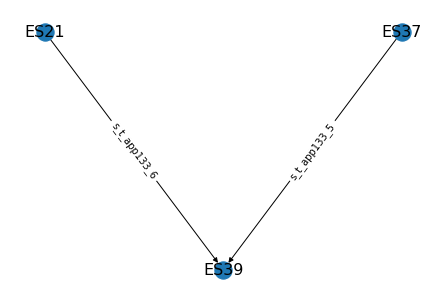

Creating apps with 7 tasks


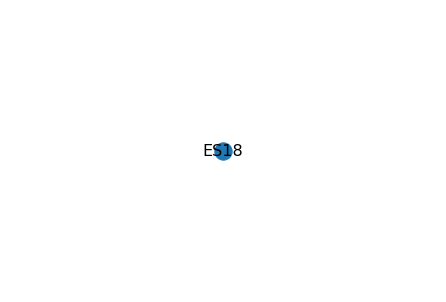

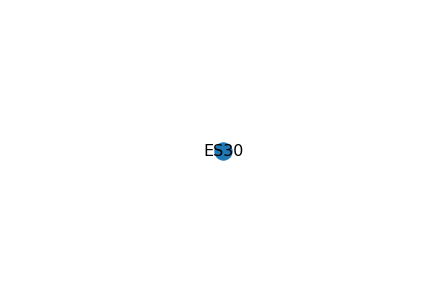

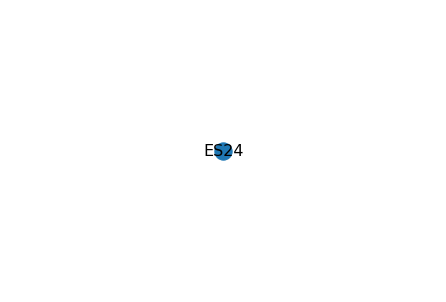

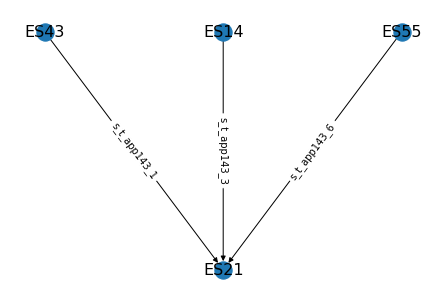

Creating apps with 7 tasks


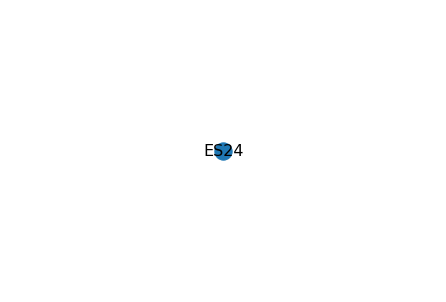

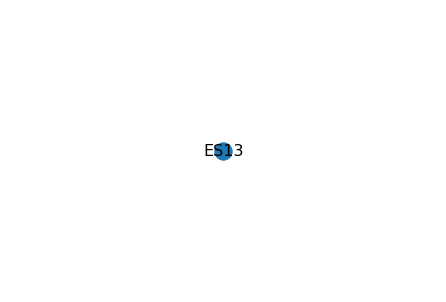

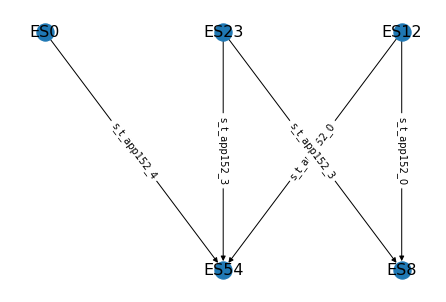

Creating apps with 7 tasks


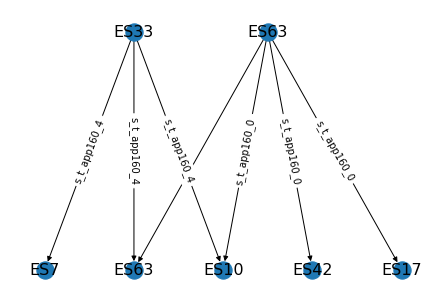

Creating apps with 7 tasks


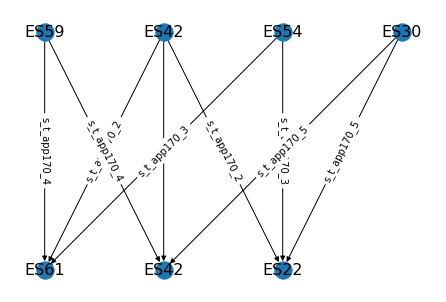

Creating apps with 7 tasks


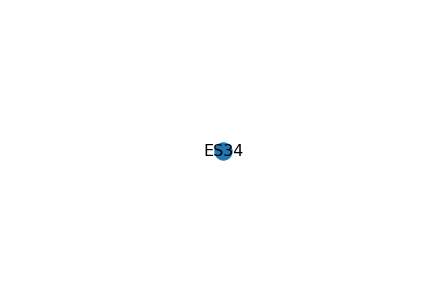

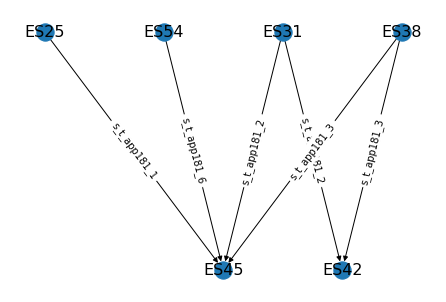

Created testcase at: C:\Users\phd\Nextcloud\PhD\Projects\tesla_publish\testcases\synthetic4\huge3.flex_network_description
Tasks 133; Streams 66; Apps 35; Average ES utilization 0.08568130208333334
--------------------------------------------------
Found possible graph. Is connected: True


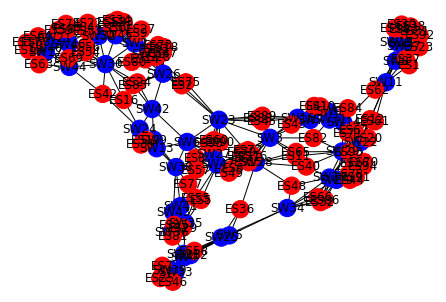

Creating apps with 7 tasks


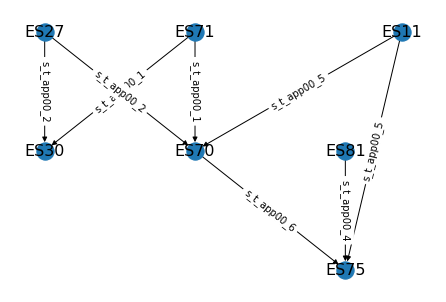

Creating apps with 7 tasks


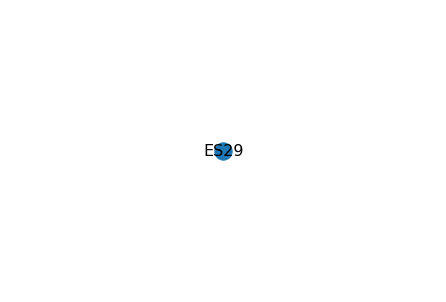

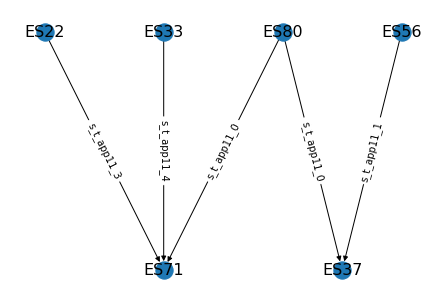

Creating apps with 7 tasks


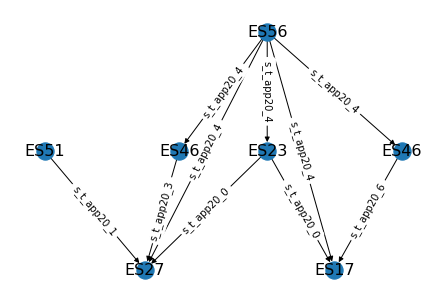

Creating apps with 7 tasks


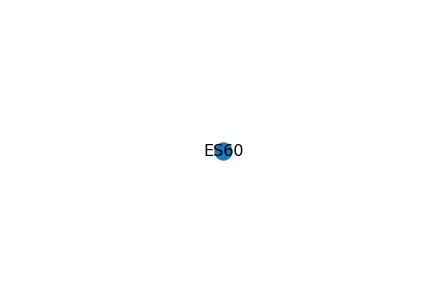

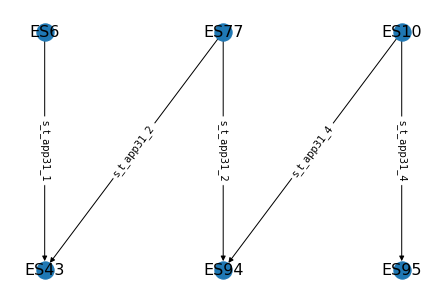

Creating apps with 7 tasks


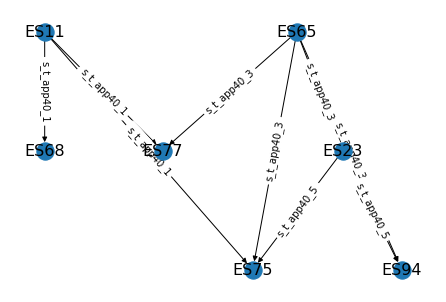

Creating apps with 7 tasks


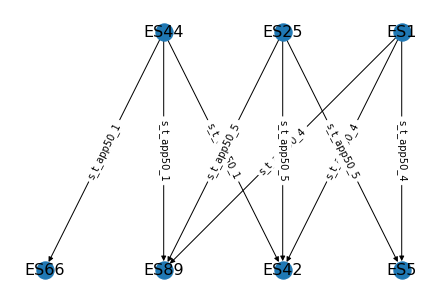

Creating apps with 7 tasks


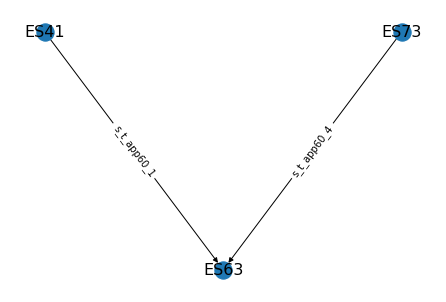

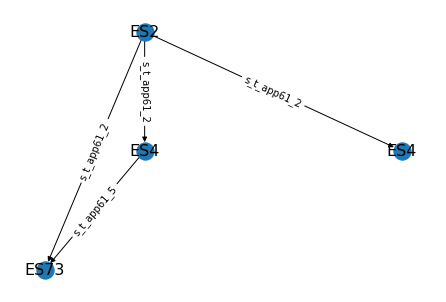

Creating apps with 7 tasks


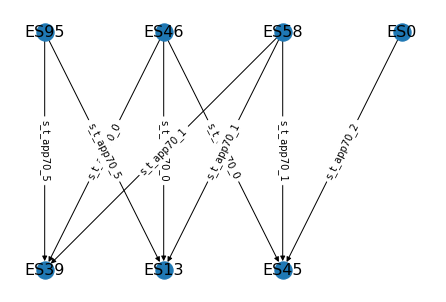

Creating apps with 7 tasks


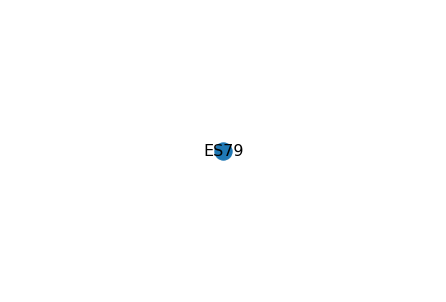

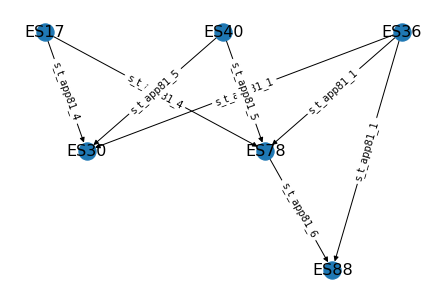

Creating apps with 7 tasks


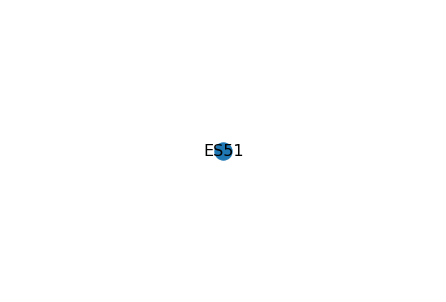

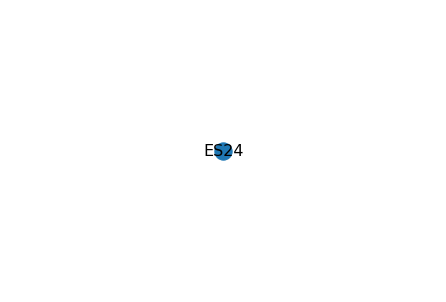

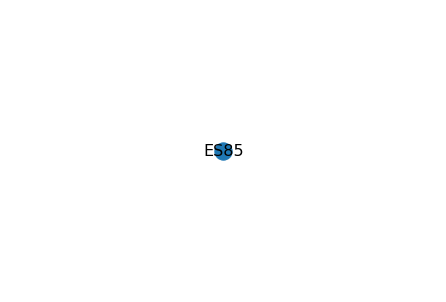

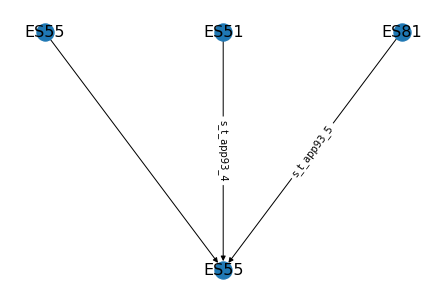

Creating apps with 7 tasks


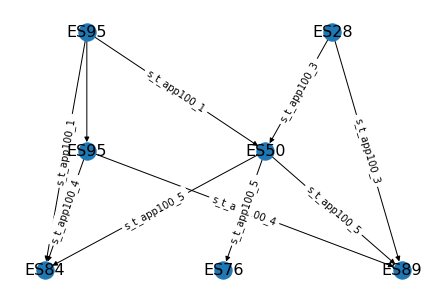

Creating apps with 7 tasks


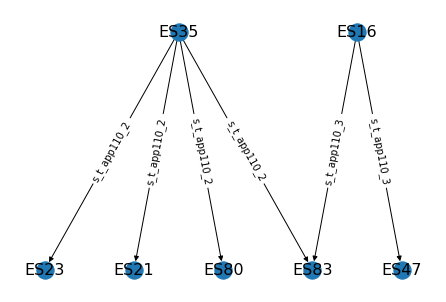

Creating apps with 7 tasks


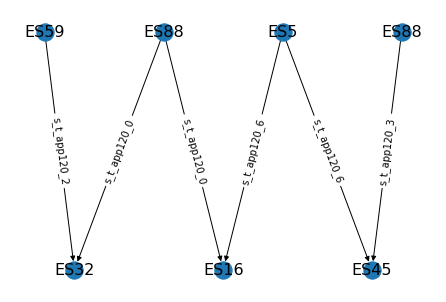

Creating apps with 7 tasks


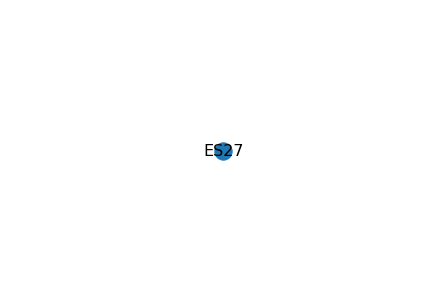

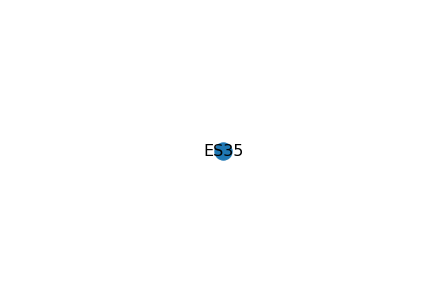

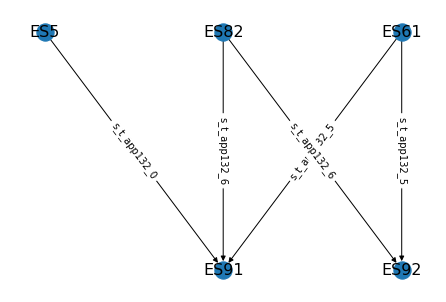

Creating apps with 7 tasks


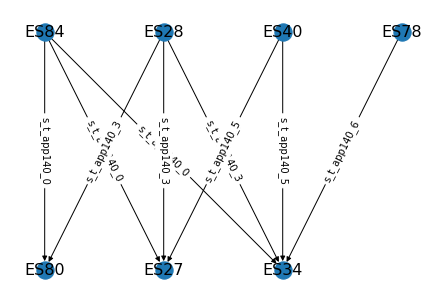

Creating apps with 7 tasks


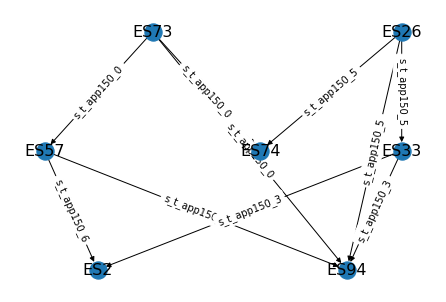

Creating apps with 7 tasks


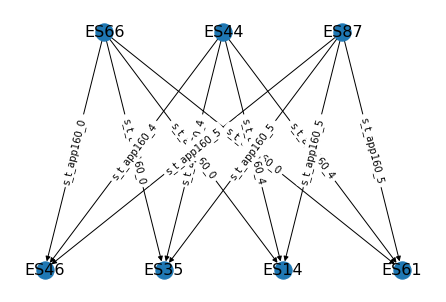

Creating apps with 7 tasks


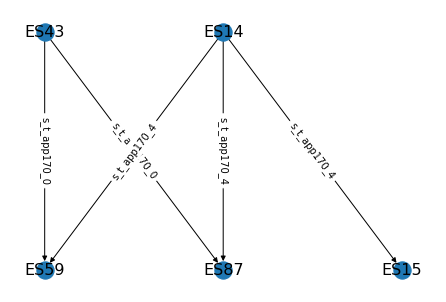

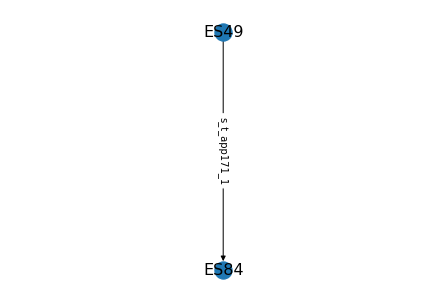

Creating apps with 7 tasks


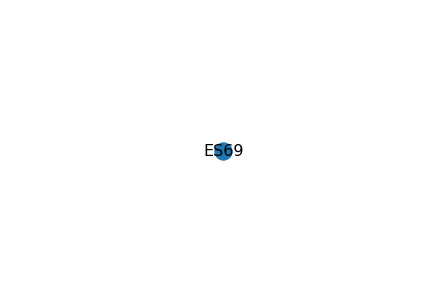

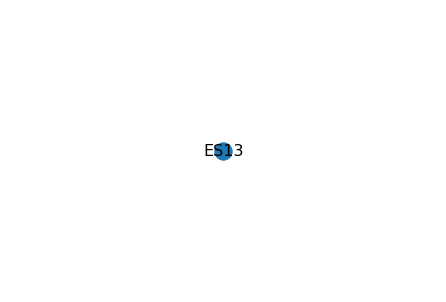

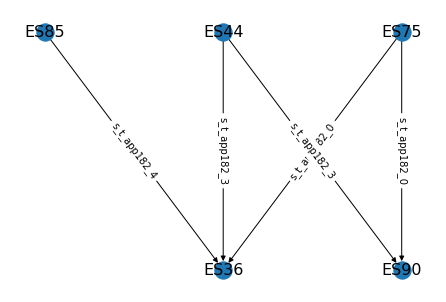

Creating apps with 7 tasks


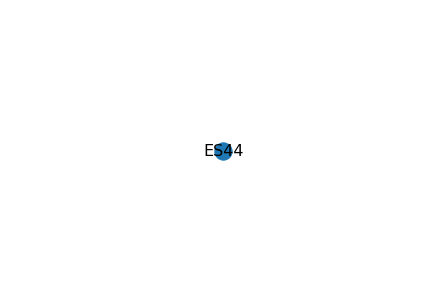

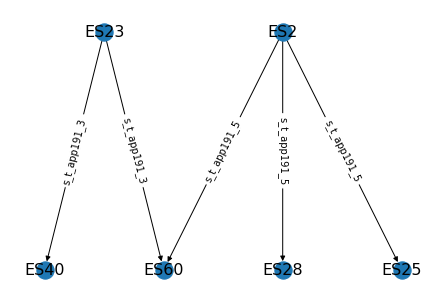

Creating apps with 7 tasks


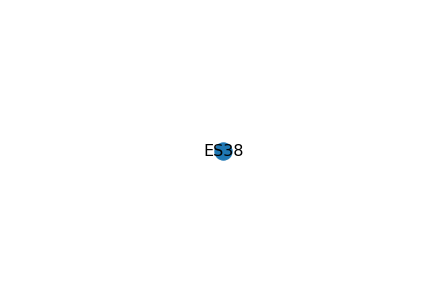

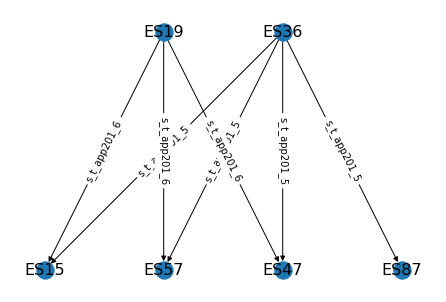

Creating apps with 7 tasks


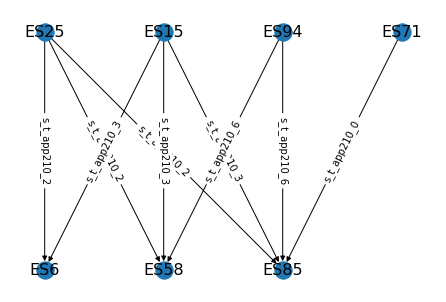

Creating apps with 7 tasks


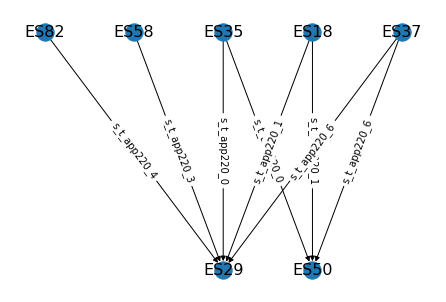

Creating apps with 7 tasks


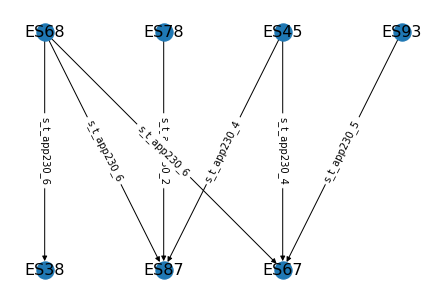

Creating apps with 7 tasks


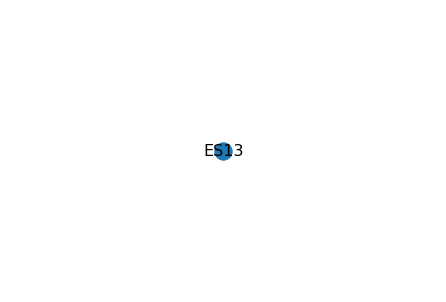

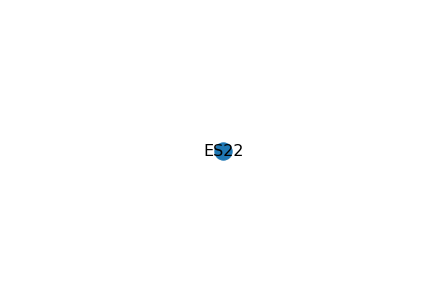

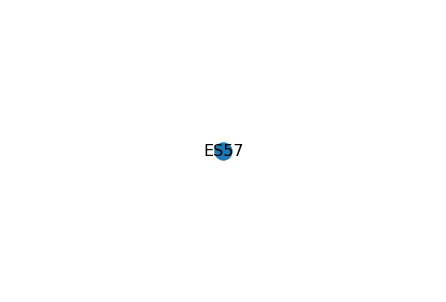

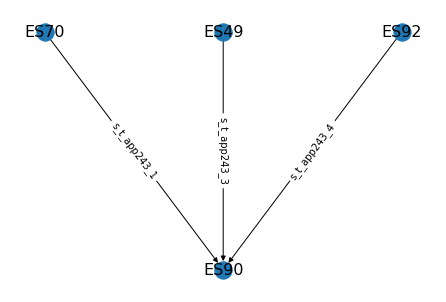

Creating apps with 7 tasks


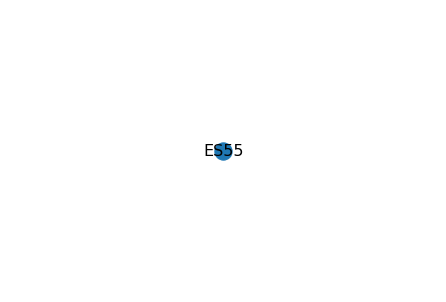

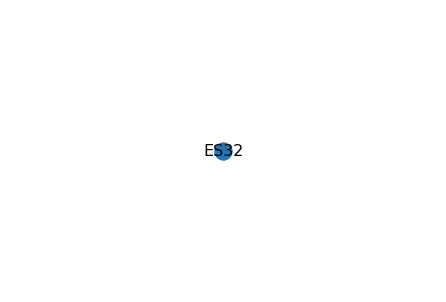

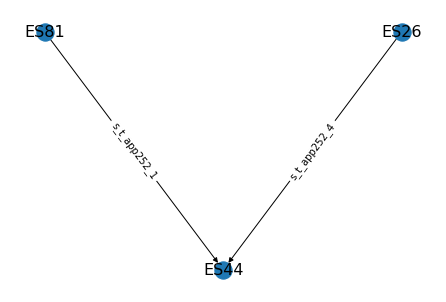

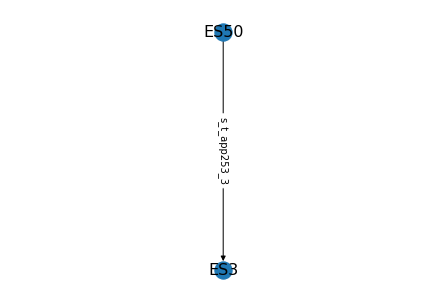

Created testcase at: C:\Users\phd\Nextcloud\PhD\Projects\tesla_publish\testcases\synthetic4\giant1.flex_network_description
Tasks 182; Streams 90; Apps 46; Average ES utilization 0.07557427083333333
--------------------------------------------------


In [5]:
nr_sws = [2, 2, 2, 4, 4, 4, 8, 8, 8, 16, 16, 16, 24, 24, 24, 32, 64, 128]
nr_tasks = [4, 6, 8, 16, 20, 24, 28, 32, 36, 50, 60, 70, 100, 125, 150, 200, 400, 800]
tc_name = ["tiny1", "tiny2", "tiny3", "small1", "small2", "small3", "medium1", "medium2", "medium3", "large1", "large2", "large3", "huge1", "huge2", "huge3", "giant1", "giant2", "giant3"]

nr_sws = [32, 48]
nr_tasks = [150, 200]
tc_name = ["huge3", "giant1"]

for i in range(2):
    config = testcase_generation_config()
    
    config.nr_sw = nr_sws[i]
    config.stream_max_rl = min(config.nr_sw, 3)
    config.nr_es = config.nr_sw * 2
    config.connections_per_sw = min(config.nr_sw-1, 4)
    config.connections_per_es = min(config.nr_sw, config.stream_max_rl)
    
    # 1500 Byte = 12us 
    config.periods = [10000, 15000, 20000, 50000]
    config.max_task_period_percentage = 0.08
    config.app_task_connection_probability = 0.6
    config.nr_tasks = nr_tasks[i]
    config.nr_dags = (config.nr_tasks // 8) + 1
    
    config.name = tc_name[i]
    path = create_testcase(config, Path("testcases/synthetic4/" + config.name + ".flex_network_description"))
    #solution_object = main.run(InputParameters(EMode.VIEW, Timeouts(0, 0, 0), path, True, "", 8050, False, False, False))

In [3]:
solution_object = main.run(InputParameters(EMode.VIEW, Timeouts(0, 0, 0), "testcases/synthetic/testcase1_4_2.flex_network_description", True, "", 8050, False, False, False))


--------------------------------------------------------------------------------
Testcase: testcase1_4_2
Mode 0: View/Check the testcase. Doesn't generate/optimize anything
Timeout Pint: 0s
Timeout Routing: 0s
Timeout Scheduling: 0
(If combined routing+scheduling, Timeout Scheduling is used)
No redundancy: False
No security: False
Overlap allowed for CP: False
--------------------------------------------------------------------------------

---------- 1. Running the chosen mode
-------------------- Parsed testcase: testcase1_4_2, in 2.00 ms
---------- 2. Serializing the solution
-------------------- Serialized solution to: testcases\output\testcase1_4_2_mode0_0_0_0_FFF_0.6,  in 3739.00 ms
---------- 3. Printing results
testcase1_4_2: 4 ES, 2 SW, 12 Tasks, 4 Streams, -1 Cost, -100.00% Bandwidth , -100.00% CPU , 0.00ms Optimization Time, Missed Deadlines 0/0, Routing NOT_OPTIMIZED, Scheduling NOT_OPTIMIZED
--------------------------



In [8]:
visualize_topo(solution_object)

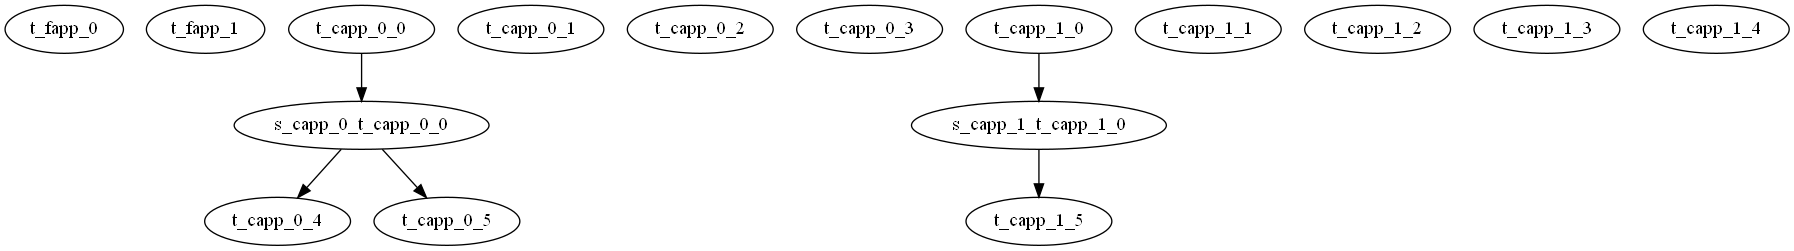

In [9]:
visualize_DAGs(solution_object)